# Data Cleaning

In [1]:
# Import the required libraries
import os
import glob
import concurrent.futures
import shutil
import pandas as pd
import numpy as np
import glob
from datetime import datetime, timedelta
import json
import requests
import time
import requests_cache
from retry_requests import retry
from tqdm import tqdm
import re
import ast
import pandas as pd
import requests_cache
from retry_requests import retry
from concurrent.futures import ThreadPoolExecutor
import xarray as xr
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Set working directory
os.chdir('C:/Users/Oke/Documents/Personal/MOBI Analytics/Wind Curtailment Forecasting')

In [8]:
boalf = pd.read_parquet('data/raw/boalf/boalf.parquet')
boalf.sort_values(by=['settlementDate', 'settlementPeriodFrom'], inplace=True)
boalf.head()

,settlementDate,settlementPeriodFrom,settlementPeriodTo,timeFrom,timeTo,levelFrom,levelTo,nationalGridBmUnit,bmUnit,acceptanceNumber,acceptanceTime,deemedBoFlag,soFlag,storFlag,rrFlag
106806,2023-12-31,48,1,2023-12-31T23:56:00Z,2024-01-01T00:26:00Z,27,27,BURBW-1,E_BURBO,39429,2023-12-31T23:41:00Z,False,False,False,False
426730,2023-12-31,48,1,2023-12-31T23:30:00Z,2024-01-01T00:06:00Z,200,200,HOWBO-2,T_HOWBO-2,1777,2023-12-31T23:28:00Z,False,False,False,False
890064,2023-12-31,48,1,2023-12-31T23:58:00Z,2024-01-01T00:04:00Z,100,100,TKNEW-1,T_TKNEW-1,2113,2023-12-31T23:56:00Z,False,False,False,False
890065,2023-12-31,48,1,2023-12-31T23:57:00Z,2024-01-01T00:05:00Z,100,412,TKNEW-1,T_TKNEW-1,2111,2023-12-31T23:46:00Z,False,False,False,False
890066,2023-12-31,48,1,2023-12-31T23:56:00Z,2024-01-01T00:00:00Z,250,412,TKNEW-1,T_TKNEW-1,2110,2023-12-31T23:20:00Z,False,False,False,False


## BMUS

In [3]:
# Ingest data
bmus = pd.read_parquet(r'data/raw/bmus/bmUnits.parquet')

# Data cleaning for bmus
bmus = bmus.dropna(subset=['elexonBmUnit'])
# Drop rows where elexonBmUnit is 'None'
bmus = bmus[bmus['elexonBmUnit'] != 'None']
# Filter for wind fuel type only
bmus = bmus[bmus['fuelType'] == 'WIND']
# Drop unnecessary columns
bmus_cleaned = bmus.drop(columns=['nationalGridBmUnit', 'eic', 'fuelType',
       'bmUnitType', 'fpnFlag', 'leadPartyId',
       'productionOrConsumptionFlag', 'demandCapacity',
       'transmissionLossFactor', 'workingDayCreditAssessmentImportCapability',
       'nonWorkingDayCreditAssessmentImportCapability',
       'workingDayCreditAssessmentExportCapability',
       'nonWorkingDayCreditAssessmentExportCapability',
       'creditQualifyingStatus', 'demandInProductionFlag', 'gspGroupId',
       'gspGroupName', 'interconnectorId'])
# Rename columns
bmus_cleaned = bmus_cleaned.rename(columns={
    'elexonBmUnit': 'bmUnit'
})

# Update bmUnitName for specific bmUnits
update_dict = {
    'T_ABRBO-1': 'Aberdeen Offshore Wind Farm',
    'T_GYMR-15': 'Gwynt y Mor Offshore WF',
    'T_GYMR-17': 'Gwynt y Mor Offshore WF',
    'T_GYMR-26': 'Gwynt y Mor Offshore WF',
    'T_GYMR-28': 'Gwynt y Mor Offshore WF',
    'T_PNYCW-1': 'Pen y Cymoedd Wind Farm Ltd.',
    'T_RCBKO-1': 'Race Bank Wind Farm',
    'T_RCBKO-2': 'Race Bank Wind Farm',
}

# Update the bmUnitName for specified bmUnits
for bmunit, new_name in update_dict.items():
    bmus_cleaned.loc[bmus_cleaned['bmUnit'] == bmunit, 'bmUnitName'] = new_name

## BOALF

In [4]:
# Ingest data
boalf = pd.read_parquet(r'data/raw/boalf/boalf.parquet')

# Drop unnecessary columns
boalf.drop(columns=['nationalGridBmUnit', 'acceptanceNumber', 'acceptanceTime', 'deemedBoFlag', 'storFlag', 'rrFlag'], inplace=True)
boalf_cleaned = boalf
boalf_cleaned = boalf_cleaned.sort_values(by=['settlementDate', 'settlementPeriodFrom','bmUnit']).reset_index(drop=True)
boalf_cleaned = boalf_cleaned.rename(columns={'levelFrom': 'boal_levelFrom', 'levelTo': 'boal_levelTo'})
# Drop duplicates
boalf_cleaned = boalf_cleaned.drop_duplicates()
boalf_cleaned.head()

,settlementDate,settlementPeriodFrom,settlementPeriodTo,timeFrom,timeTo,boal_levelFrom,boal_levelTo,bmUnit,soFlag
0,2023-12-31,48,1,2023-12-31T23:56:00Z,2024-01-01T00:26:00Z,27,27,E_BURBO,False
1,2023-12-31,48,1,2023-12-31T23:30:00Z,2024-01-01T00:06:00Z,200,200,T_HOWBO-2,False
2,2023-12-31,48,1,2023-12-31T23:58:00Z,2024-01-01T00:04:00Z,100,100,T_TKNEW-1,False
3,2023-12-31,48,1,2023-12-31T23:57:00Z,2024-01-01T00:05:00Z,100,412,T_TKNEW-1,False
4,2023-12-31,48,1,2023-12-31T23:56:00Z,2024-01-01T00:00:00Z,250,412,T_TKNEW-1,False


In [5]:
boalf_cleaned.columns

Index(['settlementDate', 'settlementPeriodFrom', 'settlementPeriodTo',
       'timeFrom', 'timeTo', 'boal_levelFrom', 'boal_levelTo', 'bmUnit',
       'soFlag'],
      dtype='object')

## FPN

In [6]:
# Ingest data
fpn = pd.read_parquet(r'data/raw/fpn/fpn.parquet')

# Drop unnecessary columns
fpn_cleaned = fpn.drop(columns=['nationalGridBmUnit', 'dataset'])

# Sort the DataFrame by 'bmUnit' and settlement details
fpn_cleaned.sort_values(by=['bmUnit','settlementDate', 'settlementPeriod'], inplace=True)

# Rename columns for clarity
fpn_cleaned = fpn_cleaned.rename(columns={'levelFrom': 'fpn_levelFrom', 'levelTo': 'fpn_levelTo'})

# Drop duplicates
fpn_cleaned = fpn_cleaned.drop_duplicates()
fpn_cleaned.head()

,settlementDate,settlementPeriod,timeFrom,timeTo,fpn_levelFrom,fpn_levelTo,bmUnit
337,2023-12-31,48,2023-12-31T23:30:00Z,2024-01-01T00:00:00Z,1,1,2__PEDGE003
336,2024-01-01,1,2024-01-01T00:00:00Z,2024-01-01T00:30:00Z,3,3,2__PEDGE003
335,2024-01-01,2,2024-01-01T00:30:00Z,2024-01-01T01:00:00Z,3,3,2__PEDGE003
334,2024-01-01,3,2024-01-01T01:00:00Z,2024-01-01T01:30:00Z,4,4,2__PEDGE003
333,2024-01-01,4,2024-01-01T01:30:00Z,2024-01-01T02:00:00Z,4,4,2__PEDGE003


In [7]:
fpn_cleaned.columns

Index(['settlementDate', 'settlementPeriod', 'timeFrom', 'timeTo',
       'fpn_levelFrom', 'fpn_levelTo', 'bmUnit'],
      dtype='object')

## WINDFOR

In [6]:
# Ingest data
windfor = pd.read_parquet(r'data/raw/windfor/windfor.parquet')

# Data cleaning for windfor
windfor_cleaned = windfor.drop(columns=['publishTime', 'settlementDate', 'settlementPeriod'])
windfor_cleaned = windfor_cleaned.rename(columns={'startTime': 'time', 'generation': 'sys_wind_gen_forecast'})
windfor_cleaned['time'] = pd.to_datetime(windfor_cleaned['time'])

# Prepare wind generation forecast in half-hourly resolution (same value for both half-hours)
windfor_half_hourly = []
for idx, row in windfor_cleaned.iterrows():
    for offset in [0, 30]:
        windfor_half_hourly.append({
            'half_hour_time': row['time'] + pd.Timedelta(minutes=offset),
            'sys_wind_gen_forecast': row['sys_wind_gen_forecast']
        })
windfor_cleaned = pd.DataFrame(windfor_half_hourly)
windfor_cleaned['half_hour_time'] = pd.to_datetime(windfor_cleaned['half_hour_time']).dt.tz_localize(None)
windfor_cleaned.head()

,half_hour_time,sys_wind_gen_forecast
0,2024-01-01 00:00:00,11453
1,2024-01-01 00:30:00,11453
2,2024-01-01 01:00:00,11838
3,2024-01-01 01:30:00,11838
4,2024-01-01 02:00:00,12090


## DEMANDFOR

In [7]:
# Ingest data
demandfor = pd.read_parquet(r'data/raw/demandfor/demandfor.parquet')

# Convert TARGETDATE to datetime if not already
demandfor['TARGETDATE'] = pd.to_datetime(demandfor['TARGETDATE'])

# Generate continuous half-hourly forecast demand from demandfor
# Assign the full FORECASTDEMAND value to each half-hour in the interval (sustained demand)
# Fill missing half-hours by forward filling from previous, and fill first slot with first available forecast

def parse_cp_time(cp_time):
    """Convert CP time string like '30', '230' to minutes past midnight."""
    cp_time_str = str(int(cp_time)).zfill(4)
    hour = int(cp_time_str[:-2])
    minute = int(cp_time_str[-2:])
    return hour * 60 + minute

all_days_rows = []

for day, group in demandfor.groupby('TARGETDATE'):
    # Generate all 48 half-hour slots for the day
    half_hour_times = [pd.Timestamp(day) + pd.Timedelta(minutes=30 * i) for i in range(48)]
    slot_dict = {h: None for h in half_hour_times}

    group = group.sort_values(['CP_ST_TIME', 'CP_END_TIME']).reset_index(drop=True)
    n = len(group)
    for i, row in group.iterrows():
        st_min = parse_cp_time(row['CP_ST_TIME'])
        end_min = parse_cp_time(row['CP_END_TIME'])
        # If start == end, treat as a single half-hour slot
        if st_min == end_min:
            next_st_min = None
            if i + 1 < n:
                next_st_min = parse_cp_time(group.iloc[i + 1]['CP_ST_TIME'])
            interval_end = next_st_min if next_st_min is not None else st_min + 30
        else:
            interval_end = end_min
        half_hours = list(range(st_min, interval_end, 30))
        for offset_min in half_hours:
            half_hour_time = pd.Timestamp(day) + pd.Timedelta(minutes=offset_min)
            slot_dict[half_hour_time] = row['FORECASTDEMAND']  # assign full value

    # Forward fill missing slots, fill first slot with first available forecast
    slot_times = sorted(slot_dict.keys())
    values = [slot_dict[t] for t in slot_times]
    # Find first non-None value
    first_val = next((v for v in values if v is not None), None)
    filled_values = []
    prev_val = first_val
    for v in values:
        if v is not None:
            prev_val = v
        filled_values.append(prev_val)
    # Build rows
    for t, v in zip(slot_times, filled_values):
        all_days_rows.append({
            'TARGETDATE': day,
            'half_hour_time': t,
            'FORECASTDEMAND_half_hour': v
        })

demandfor_cleaned = pd.DataFrame(all_days_rows)
demandfor_cleaned = demandfor_cleaned.sort_values(['TARGETDATE', 'half_hour_time']).reset_index(drop=True)
demandfor_cleaned = demandfor_cleaned.rename(columns={
    'FORECASTDEMAND_half_hour' : 'sys_demand_forecast'
})
demandfor_cleaned.head()

,TARGETDATE,half_hour_time,sys_demand_forecast
0,2024-01-01,2024-01-01 00:00:00,23065
1,2024-01-01,2024-01-01 00:30:00,23065
2,2024-01-01,2024-01-01 01:00:00,23432
3,2024-01-01,2024-01-01 01:30:00,23432
4,2024-01-01,2024-01-01 02:00:00,23432


## DA Constraints and Flows

In [8]:
# Ingest data
constraints = pd.read_csv(r'data/raw/da_constraints/da_constraints.csv')

# Change to datetime format
constraints['Date (GMT/BST)'] = pd.to_datetime(
    constraints['Date (GMT/BST)'], 
    errors='coerce', 
    format='mixed'
)

# Pivot constraints_filtered so each Constraint Group has its Limit and Flow in separate columns
constraints_cleaned = constraints.pivot_table(
    index=['Date (GMT/BST)'],
    columns='Constraint Group',
    values=['Limit (MW)', 'Flow (MW)']
)

# Flatten MultiIndex columns for easier use
constraints_cleaned.columns = [
    f"{col[1]}_{col[0].replace(' (MW)', '').replace(' ', '_')}"
    for col in constraints_cleaned.columns
]

constraints_cleaned = constraints_cleaned.reset_index()

# Drop columns with 100% missing values
constraints_cleaned = constraints_cleaned.drop(columns=['GETEX_Flow', 'GETEX_Limit'])

constraints_cleaned.head()

,Date (GMT/BST),ERROEX_Flow,ESTEX_Flow,FLOWSTH_Flow,GALLEX_Flow,GM+SNOW5A_Flow,HARSPNBLY_Flow,NKILGRMO_Flow,SCOTEX_Flow,SEIMPPR21_Flow,...,HARSPNBLY_Limit,NKILGRMO_Limit,SCOTEX_Limit,SEIMPPR21_Limit,SEIMPPR23_Limit,SEIMPPR33_Limit,SSE-SP2_Limit,SSEN-S_Limit,SSHARN3_Limit,SSHARN7_Limit
0,2024-04-21 00:00:00,82.0,NaN,651.0,10.0,32.0,NaN,-3.0,-893.0,NaN,...,NaN,2450.0,2800.0,NaN,6050.0,NaN,1800.0,1800.0,6000.0,NaN
1,2024-04-21 00:30:00,85.0,NaN,863.0,9.0,78.0,NaN,-2.0,-871.0,NaN,...,NaN,2450.0,2800.0,NaN,6050.0,NaN,1800.0,1800.0,6000.0,NaN
2,2024-04-21 01:00:00,86.0,NaN,871.0,7.0,-135.0,NaN,26.0,-848.0,NaN,...,NaN,2450.0,2800.0,NaN,6050.0,NaN,1800.0,1800.0,6000.0,NaN
3,2024-04-21 01:30:00,85.0,NaN,921.0,7.0,72.0,NaN,12.0,-868.0,NaN,...,NaN,2450.0,2800.0,NaN,6050.0,NaN,1800.0,1800.0,6000.0,NaN
4,2024-04-21 02:00:00,83.0,NaN,783.0,9.0,-252.0,NaN,29.0,-855.0,NaN,...,NaN,2450.0,2800.0,NaN,6050.0,NaN,1800.0,1800.0,6000.0,NaN


# Model Training

In [9]:
# Ingest data
features = pd.read_parquet(r'data/processed/features.parquet')
features.head()

,bmUnit,curtailment_mwh,settlement_period_time,curtailment_flag,sys_demand_forecast,sys_wind_gen_forecast,ERROEX_Flow,ESTEX_Flow,FLOWSTH_Flow,GALLEX_Flow,...,SEIMPPR21_Limit,SEIMPPR23_Limit,SEIMPPR33_Limit,SSE-SP2_Limit,SSEN-S_Limit,SSHARN3_Limit,SSHARN7_Limit,generationCapacity,hour,month
0,2__PEDGE003,0.0,2024-01-01 00:00:00,0,23065,11453.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000,0,1
1,2__PEDGE003,0.0,2024-01-01 00:30:00,0,23065,11453.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000,0,1
2,2__PEDGE003,0.0,2024-01-01 01:00:00,0,23432,11838.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000,1,1
3,2__PEDGE003,0.0,2024-01-01 01:30:00,0,23432,11838.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000,1,1
4,2__PEDGE003,0.0,2024-01-01 02:00:00,0,23432,12090.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000,2,1


In [10]:
features.columns

Index(['bmUnit', 'curtailment_mwh', 'settlement_period_time',
       'curtailment_flag', 'sys_demand_forecast', 'sys_wind_gen_forecast',
       'ERROEX_Flow', 'ESTEX_Flow', 'FLOWSTH_Flow', 'GALLEX_Flow',
       'GM+SNOW5A_Flow', 'HARSPNBLY_Flow', 'NKILGRMO_Flow', 'SCOTEX_Flow',
       'SEIMPPR21_Flow', 'SEIMPPR23_Flow', 'SEIMPPR33_Flow', 'SSE-SP2_Flow',
       'SSEN-S_Flow', 'SSHARN3_Flow', 'SSHARN7_Flow', 'ERROEX_Limit',
       'ESTEX_Limit', 'FLOWSTH_Limit', 'GALLEX_Limit', 'GM+SNOW5A_Limit',
       'HARSPNBLY_Limit', 'NKILGRMO_Limit', 'SCOTEX_Limit', 'SEIMPPR21_Limit',
       'SEIMPPR23_Limit', 'SEIMPPR33_Limit', 'SSE-SP2_Limit', 'SSEN-S_Limit',
       'SSHARN3_Limit', 'SSHARN7_Limit', 'generationCapacity', 'hour',
       'month'],
      dtype='object')

In [11]:
# Aggregate features to system-level by grouping by settlement_period_time

# Convert generationCapacity to numeric before aggregation
features['generationCapacity'] = pd.to_numeric(features['generationCapacity'], errors='coerce')

features = features.groupby('settlement_period_time').agg({
    'curtailment_mwh': 'sum',
    'curtailment_flag': 'max',  # If any BMU had curtailment, flag the period
    'bmUnit': 'nunique',  # Number of unique BMUs
    'generationCapacity':'sum',
    'sys_wind_gen_forecast': 'first',  # Same for all half-hours
    'sys_demand_forecast': 'first',  # Same for all half-hours
    'ERROEX_Flow': 'first',
    'ERROEX_Limit': 'first',
    'ESTEX_Flow': 'first',
    'ESTEX_Limit': 'first',
    'FLOWSTH_Flow': 'first',
    'FLOWSTH_Limit': 'first',
    'GALLEX_Flow': 'first',
    'GALLEX_Limit': 'first',
    'GM+SNOW5A_Flow': 'first',
    'GM+SNOW5A_Limit': 'first',
    'HARSPNBLY_Flow': 'first',
    'HARSPNBLY_Limit': 'first',
    'NKILGRMO_Flow': 'first',
    'NKILGRMO_Limit': 'first',
    'SCOTEX_Flow': 'first',
    'SCOTEX_Limit': 'first',
    'SEIMPPR21_Flow': 'first',
    'SEIMPPR21_Limit': 'first',
    'SEIMPPR23_Flow': 'first',
    'SEIMPPR23_Limit': 'first',
    'SEIMPPR33_Flow': 'first',
    'SEIMPPR33_Limit': 'first',
    'SSE-SP2_Flow': 'first',
    'SSE-SP2_Limit': 'first',
    'SSEN-S_Flow': 'first',
    'SSEN-S_Limit': 'first',
    'SSHARN3_Flow': 'first',
    'SSHARN3_Limit': 'first',
    'SSHARN7_Flow': 'first',
    'SSHARN7_Limit': 'first',
    'hour': 'first',
    'month': 'first',
}).reset_index()
features = features.sort_values('settlement_period_time').reset_index(drop=True)
features.head()

,settlement_period_time,curtailment_mwh,curtailment_flag,bmUnit,generationCapacity,sys_wind_gen_forecast,sys_demand_forecast,ERROEX_Flow,ERROEX_Limit,ESTEX_Flow,...,SSE-SP2_Flow,SSE-SP2_Limit,SSEN-S_Flow,SSEN-S_Limit,SSHARN3_Flow,SSHARN3_Limit,SSHARN7_Flow,SSHARN7_Limit,hour,month
0,2024-01-01 00:00:00,0.0,0,194,37184.352,11453.0,23065,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2024-01-01 00:30:00,0.0,0,194,31441.734,11453.0,23065,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2024-01-01 01:00:00,0.0,0,194,29415.334,11838.0,23432,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,2024-01-01 01:30:00,0.0,0,194,28931.734,11838.0,23432,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,2024-01-01 02:00:00,0.0,0,194,28925.334,12090.0,23432,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1


Final day-ahead dataframe shape: (30673, 41)

Feature breakdown:
Day-ahead forecast features: 30673

Missing values in day-ahead dataset:
Total missing values: 377,523
Features with missing values:
  sys_wind_gen_forecast: 47
  ERROEX_Flow: 5,818
  ERROEX_Limit: 5,818
  ESTEX_Flow: 30,625
  ESTEX_Limit: 30,625
  FLOWSTH_Flow: 5,864
  FLOWSTH_Limit: 5,864
  GALLEX_Flow: 6,302
  GALLEX_Limit: 6,302
  GM+SNOW5A_Flow: 5,522
  GM+SNOW5A_Limit: 5,522
  HARSPNBLY_Flow: 5,764
  HARSPNBLY_Limit: 5,764
  NKILGRMO_Flow: 7,638
  NKILGRMO_Limit: 7,638
  SCOTEX_Flow: 5,540
  SCOTEX_Limit: 5,540
  SEIMPPR21_Flow: 30,193
  SEIMPPR21_Limit: 30,193
  SEIMPPR23_Flow: 7,084
  SEIMPPR23_Limit: 7,084
  SEIMPPR33_Flow: 30,625
  SEIMPPR33_Limit: 30,625
  SSE-SP2_Flow: 5,474
  SSE-SP2_Limit: 5,474
  SSEN-S_Flow: 6,190
  SSEN-S_Limit: 6,190
  SSHARN3_Flow: 5,474
  SSHARN3_Limit: 5,474
  SSHARN7_Flow: 30,625
  SSHARN7_Limit: 30,625

Day-ahead curtailment summary:
Total settlement periods: 30,673
Periods with cur

c:\Users\Oke\Documents\Personal\MOBI Analytics\Wind Curtailment Forecasting\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found by RandomizedSearchCV (Day-ahead):
{'use_label_encoder': False, 'tree_method': 'hist', 'subsample': 0.8, 'scale_pos_weight': 0.7054054054054054, 'random_state': 42, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'lambda': 10, 'gamma': 0.3, 'eval_metric': 'logloss', 'colsample_bytree': 0.6, 'alpha': 1}


c:\Users\Oke\Documents\Personal\MOBI Analytics\Wind Curtailment Forecasting\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:41:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Top 20 selected features for final model:
['generationCapacity', 'SSHARN3_Flow', 'SCOTEX_Flow', 'sys_wind_gen_forecast', 'HARSPNBLY_Flow', 'SSE-SP2_Flow', 'bmUnit', 'HARSPNBLY_Limit', 'NKILGRMO_Flow', 'SSEN-S_Flow', 'SSE-SP2_Limit', 'ERROEX_Limit', 'month_sin', 'SSEN-S_Limit', 'SCOTEX_Limit', 'GM+SNOW5A_Limit', 'NKILGRMO_Limit', 'GM+SNOW5A_Flow', 'SSHARN3_Limit', 'hour_cos']
[0]	validation_0-logloss:0.68806
[1]	validation_0-logloss:0.68184


c:\Users\Oke\Documents\Personal\MOBI Analytics\Wind Curtailment Forecasting\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:41:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[2]	validation_0-logloss:0.67825
[3]	validation_0-logloss:0.67241
[4]	validation_0-logloss:0.66913
[5]	validation_0-logloss:0.66348
[6]	validation_0-logloss:0.65979
[7]	validation_0-logloss:0.65611
[8]	validation_0-logloss:0.65052
[9]	validation_0-logloss:0.64740
[10]	validation_0-logloss:0.64213
[11]	validation_0-logloss:0.63913
[12]	validation_0-logloss:0.63398
[13]	validation_0-logloss:0.62883
[14]	validation_0-logloss:0.62605
[15]	validation_0-logloss:0.62117
[16]	validation_0-logloss:0.61801
[17]	validation_0-logloss:0.61470
[18]	validation_0-logloss:0.61161
[19]	validation_0-logloss:0.60899
[20]	validation_0-logloss:0.60432
[21]	validation_0-logloss:0.60061
[22]	validation_0-logloss:0.59762
[23]	validation_0-logloss:0.59535
[24]	validation_0-logloss:0.59239
[25]	validation_0-logloss:0.58965
[26]	validation_0-logloss:0.58520
[27]	validation_0-logloss:0.58095
[28]	validation_0-logloss:0.57692
[29]	validation_0-logloss:0.57281
[30]	validation_0-logloss:0.56884
[31]	validation_0-logl

,threshold,precision,recall,f1
0,0.0000,0.6275,1.0000,0.7712
1,0.0545,0.6284,1.0000,0.7718
2,0.0548,0.6285,1.0000,0.7719
3,0.0554,0.6288,1.0000,0.7721
4,0.0556,0.6293,1.0000,0.7725
5,0.0557,0.6295,0.9997,0.7726
6,0.0558,0.6297,0.9997,0.7727
7,0.0560,0.6300,0.9997,0.7729
8,0.0561,0.6301,0.9997,0.7730
9,0.0564,0.6315,0.9997,0.7741


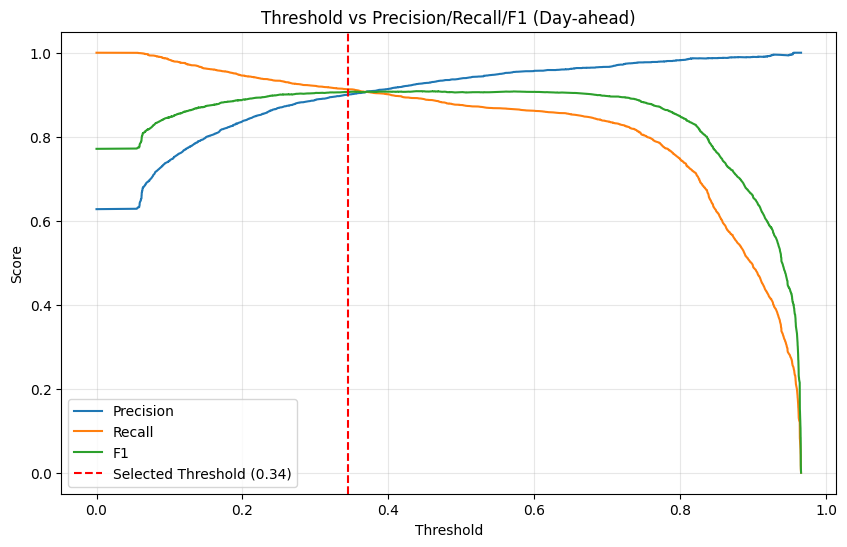


Confusion Matrix:
[[1894  391]
 [ 335 3515]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8497    0.8289    0.8392      2285
           1     0.8999    0.9130    0.9064      3850

    accuracy                         0.8817      6135
   macro avg     0.8748    0.8709    0.8728      6135
weighted avg     0.8812    0.8817    0.8814      6135

ROC-AUC: 0.9502 | PR-AUC (avg precision): 0.9718

Top 20 day-ahead features by importance (gain):
                  feature  importance
0      generationCapacity    0.247370
1            SSHARN3_Flow    0.174302
2             SCOTEX_Flow    0.108181
3   sys_wind_gen_forecast    0.096679
4          HARSPNBLY_Flow    0.096215
5            SSE-SP2_Flow    0.049875
6                  bmUnit    0.036800
7         HARSPNBLY_Limit    0.025229
8           NKILGRMO_Flow    0.021003
11           ERROEX_Limit    0.020334
13           SSEN-S_Limit    0.020043
10          SSE-SP2_Limit    0.019379
12         

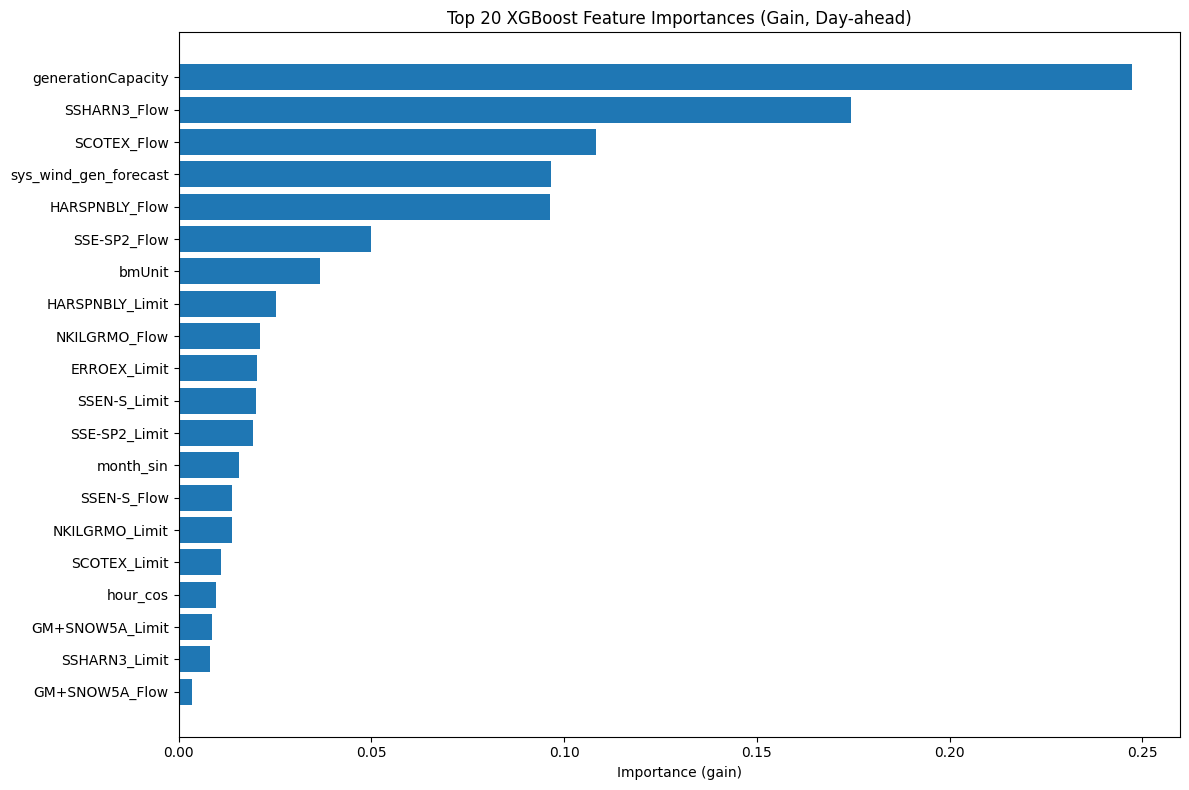


Optimized day-ahead model saved to C:\Users\Oke\Documents\Personal\MOBI Analytics\Wind Curtailment Forecasting\models\sys-day-ahead-xgb-optimal.model


c:\Users\Oke\Documents\Personal\MOBI Analytics\Wind Curtailment Forecasting\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [18:42:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [12]:
# Create cyclical features
# Hour (24-hour cycle)
features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)

# Month (12-month cycle)
features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)

# Drop original time features, keep only cyclical encodings
features = features.drop(columns=['hour', 'month'])

print(f"Final day-ahead dataframe shape: {features.shape}")

# Display feature breakdown
print(f"\nFeature breakdown:")
print(f"Day-ahead forecast features: {len(features)}")

# Check for missing values
print(f"\nMissing values in day-ahead dataset:")
missing_counts = features.isnull().sum()
print(f"Total missing values: {missing_counts.sum():,}")
if missing_counts.sum() > 0:
    print("Features with missing values:")
    for col, count in missing_counts[missing_counts > 0].items():
        print(f"  {col}: {count:,}")

# Drop records with missing curtailment_flag
initial_length = len(features)
features = features.dropna(subset=['curtailment_flag'])
final_length = len(features)
dropped_records = initial_length - final_length

if dropped_records > 0:
    print(f"\nDropped {dropped_records} records with missing curtailment_flag")
    print(f"Final dataset shape: {features.shape}")

# Display summary
print(f"\nDay-ahead curtailment summary:")
print(f"Total settlement periods: {len(features):,}")
print(f"Periods with curtailment: {features['curtailment_flag'].sum():,}")
print(f"Curtailment rate: {features['curtailment_flag'].mean():.1%}")

features.head()

# --- Day-ahead XGBoost model using sklearn API ---

import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# 1. Prepare day-ahead features and target
features = features.sort_values('settlement_period_time').reset_index(drop=True)
target_da = 'curtailment_flag'
leakage_cols_da = ['settlement_period_time', 'curtailment_mwh', target_da]
if 'year' not in features.columns:
    features['year'] = features['settlement_period_time'].dt.year
drop_cols_da = [c for c in leakage_cols_da if c in features.columns] + (['year'] if 'year' in features.columns else [])
features = features.dropna(subset=[target_da])
X_da = features.drop(columns=drop_cols_da)
y_da = features[target_da].astype(int)

# 2. Chronological train/test split (last 20% for test)
test_size = 0.20
n_total_da = len(X_da)
n_train_full_da = int(np.floor(n_total_da * (1 - test_size)))
X_train_full_da = X_da.iloc[:n_train_full_da].copy()
y_train_full_da = y_da.iloc[:n_train_full_da].copy()
X_test_da = X_da.iloc[n_train_full_da:].copy()
y_test_da = y_da.iloc[n_train_full_da:].copy()

# 3. Inner validation (last 10% of training for early stopping)
val_frac_da = 0.10
n_val_da = int(np.floor(len(X_train_full_da) * val_frac_da))
X_train_inner_da = X_train_full_da.iloc[:-n_val_da].copy()
y_train_inner_da = y_train_full_da.iloc[:-n_val_da].copy()
X_val_inner_da = X_train_full_da.iloc[-n_val_da:].copy()
y_val_inner_da = y_train_full_da.iloc[-n_val_da:].copy()

# 4. Calculate scale_pos_weight for imbalance
scale_pos_weight_da = float(y_train_inner_da.value_counts()[0]) / float(y_train_inner_da.value_counts()[1])

# 5. RandomizedSearchCV for hyperparameter tuning (sklearn API)
param_grid_da = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.3, 0.5, 1.0],
    'alpha': [0, 0.01, 0.1, 1, 10],
    'lambda': [0.1, 1, 5, 10, 20],
    'n_estimators': [100, 200, 300, 400, 500],
    'scale_pos_weight': [scale_pos_weight_da],
    'tree_method': ['hist'],
    'random_state': [42],
    'use_label_encoder': [False],
    'eval_metric': ['logloss'],
}

xgb_clf_da = xgb.XGBClassifier(n_jobs=-1)
search_da = RandomizedSearchCV(
    estimator=xgb_clf_da,
    param_distributions=param_grid_da,
    n_iter=30,
    scoring='average_precision',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
search_da.fit(X_train_inner_da, y_train_inner_da)
print("Best parameters found by RandomizedSearchCV (Day-ahead):")
print(search_da.best_params_)

# --- Feature Selection: Train on all training data and select top 20 features ---
temp_xgb_da = xgb.XGBClassifier(**search_da.best_params_)
temp_xgb_da.fit(X_train_full_da, y_train_full_da, verbose=False)
importances_da = temp_xgb_da.feature_importances_
feature_names_da = X_train_full_da.columns
imp_df_da = pd.DataFrame({'feature': feature_names_da, 'importance': importances_da})
imp_df_da = imp_df_da.sort_values('importance', ascending=False)
top_features_da = imp_df_da['feature'].head(20).tolist()
print("\nTop 20 selected features for final model:")
print(top_features_da)

# Subset train/val/test splits to top features
X_train_inner_da = X_train_inner_da[top_features_da]
X_val_inner_da = X_val_inner_da[top_features_da]
X_test_da = X_test_da[top_features_da]

# 6. Train final model with best params and early stopping
best_params_da = search_da.best_params_.copy()
for key in ['early_stopping_rounds', 'eval_set', 'verbose']:
    best_params_da.pop(key, None)

final_xgb_da = xgb.XGBClassifier(**best_params_da)
final_xgb_da.fit(
    X_train_inner_da, y_train_inner_da,
    eval_set=[(X_val_inner_da, y_val_inner_da)],
    verbose=True
)

# 7. Predict probabilities on test set
y_proba_da = final_xgb_da.predict_proba(X_test_da)[:, 1]

# 8. Threshold table and selection (0.9, 0.88, 0.85, 0.8, fallback to F1-max)
precisions_da, recalls_da, thresholds_da = precision_recall_curve(y_test_da, y_proba_da)
f1s_da = 2 * (precisions_da * recalls_da) / (precisions_da + recalls_da + 1e-12)
thr_df_da = pd.DataFrame({
    'threshold': np.concatenate(([0.0], thresholds_da)),
    'precision': precisions_da,
    'recall': recalls_da,
    'f1': f1s_da
})

precision_targets_da = [0.90, 0.88, 0.85, 0.80]
selected_row_da = None
for p_target in precision_targets_da:
    candidates_da = thr_df_da[thr_df_da['precision'] >= p_target]
    if len(candidates_da) > 0:
        selected_row_da = candidates_da.loc[candidates_da['recall'].idxmax()]
        print(f"Found threshold(s) meeting precision >= {p_target:.2f}. Choosing one that maximises recall.")
        break
if selected_row_da is None:
    idx_f1max_da = np.nanargmax(thr_df_da['f1'].values)
    selected_row_da = thr_df_da.iloc[idx_f1max_da]
    print("No threshold met preferred precision targets. Falling back to F1-maximising threshold.")

selected_threshold_da = float(selected_row_da['threshold'])
sel_prec_da = float(selected_row_da['precision'])
sel_rec_da = float(selected_row_da['recall'])
sel_f1_da = float(selected_row_da['f1'])

print(f"\nSelected threshold: {selected_threshold_da:.4f}")
print(f"Precision: {sel_prec_da:.4f}, Recall: {sel_rec_da:.4f}, F1: {sel_f1_da:.4f}")

# 9. Print threshold table and plot
print("\nThreshold trade-off table (precision / recall / f1):")
display(thr_df_da[['threshold', 'precision', 'recall', 'f1']].round(4).head(20))

plt.figure(figsize=(10, 6))
plt.plot(thr_df_da['threshold'], thr_df_da['precision'], label='Precision')
plt.plot(thr_df_da['threshold'], thr_df_da['recall'], label='Recall')
plt.plot(thr_df_da['threshold'], thr_df_da['f1'], label='F1')
plt.axvline(selected_threshold_da, color='red', linestyle='--', label=f'Selected Threshold ({selected_threshold_da:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision/Recall/F1 (Day-ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 10. Metrics and confusion matrix
y_pred_da = (y_proba_da >= selected_threshold_da).astype(int)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_da, y_pred_da))
print("\nClassification Report:")
print(classification_report(y_test_da, y_pred_da, digits=4))
roc_auc_da = roc_auc_score(y_test_da, y_proba_da)
pr_auc_da = average_precision_score(y_test_da, y_proba_da)
print(f"ROC-AUC: {roc_auc_da:.4f} | PR-AUC (avg precision): {pr_auc_da:.4f}")

# 11. Feature importance plot
importances_da = final_xgb_da.feature_importances_
feature_names_da = X_train_inner_da.columns
imp_df_da = pd.DataFrame({'feature': feature_names_da, 'importance': importances_da}).sort_values('importance', ascending=False)
print("\nTop 20 day-ahead features by importance (gain):")
print(imp_df_da.head(20))

plt.figure(figsize=(12, 8))
plt.barh(imp_df_da['feature'].head(20)[::-1], imp_df_da['importance'].head(20)[::-1])
plt.title("Top 20 XGBoost Feature Importances (Gain, Day-ahead)")
plt.xlabel("Importance (gain)")
plt.tight_layout()
plt.show()

# 12. Save model to models/sys-day-ahead-xgb-optimal.model
models_dir_da = os.path.join(os.getcwd(), "models")
os.makedirs(models_dir_da, exist_ok=True)
model_path_da = os.path.join(models_dir_da, "sys-day-ahead-xgb-optimal.model")
final_xgb_da.save_model(model_path_da)
print(f"\nOptimized day-ahead model saved to {model_path_da}")

In [4]:
import pandas as pd

# Check raw BOALF data
boalf = pd.read_parquet("data/raw/boalf/boalf.parquet")
boalf['settlementDate'] = pd.to_datetime(boalf['settlementDate'])

# Filter to 2025-11-22
nov22 = boalf[boalf['settlementDate'].dt.date == pd.Timestamp('2025-11-22').date()]

print(f"Total rows for 2025-11-22: {len(nov22)}")
print(f"Unique settlement periods: {nov22['settlementPeriod'].nunique()}")
print(f"Expected: 48 periods")
print(f"\nSettlement periods found:")
print(sorted(nov22['settlementPeriod'].unique()))

Total rows for 2025-11-22: 2


KeyError: 'settlementPeriod'

In [19]:
import pandas as pd

# Load features
#features = pd.read_parquet("data/processed/features.parquet")
#features['settlement_period_time'] = pd.to_datetime(features['settlement_period_time'])

# Filter to 2025-11-22
nov22 = features[features['settlement_period_time'].dt.date == pd.Timestamp('2025-11-23').date()]

print(f"Total BMU-level rows for 2025-11-22: {len(nov22)}")
print(f"Unique settlement_period_time values: {nov22['settlement_period_time'].nunique()}")
print(f"\nSettlement times found:")
print(sorted(nov22['settlement_period_time'].unique()))

Total BMU-level rows for 2025-11-22: 12948
Unique settlement_period_time values: 48

Settlement times found:
[Timestamp('2025-11-23 00:00:00'), Timestamp('2025-11-23 00:30:00'), Timestamp('2025-11-23 01:00:00'), Timestamp('2025-11-23 01:30:00'), Timestamp('2025-11-23 02:00:00'), Timestamp('2025-11-23 02:30:00'), Timestamp('2025-11-23 03:00:00'), Timestamp('2025-11-23 03:30:00'), Timestamp('2025-11-23 04:00:00'), Timestamp('2025-11-23 04:30:00'), Timestamp('2025-11-23 05:00:00'), Timestamp('2025-11-23 05:30:00'), Timestamp('2025-11-23 06:00:00'), Timestamp('2025-11-23 06:30:00'), Timestamp('2025-11-23 07:00:00'), Timestamp('2025-11-23 07:30:00'), Timestamp('2025-11-23 08:00:00'), Timestamp('2025-11-23 08:30:00'), Timestamp('2025-11-23 09:00:00'), Timestamp('2025-11-23 09:30:00'), Timestamp('2025-11-23 10:00:00'), Timestamp('2025-11-23 10:30:00'), Timestamp('2025-11-23 11:00:00'), Timestamp('2025-11-23 11:30:00'), Timestamp('2025-11-23 12:00:00'), Timestamp('2025-11-23 12:30:00'), Timest

In [3]:
import pandas as pd

# Load and inspect
features = pd.read_parquet("data/processed/features.parquet")
features['settlement_period_time'] = pd.to_datetime(features['settlement_period_time'])

# Filter to Dec 4
dec4 = features[features['settlement_period_time'].dt.date == pd.Timestamp('2025-12-04').date()]

print(f"Total rows for Dec 4: {len(dec4)}")
print(f"\nUnique settlement_period_time values: {dec4['settlement_period_time'].nunique()}")
print(f"\nFirst 10 unique timestamps:")
print(sorted(dec4['settlement_period_time'].unique())[:10])

# Check if times are distinct per BMU
print(f"\nSample records:")
print(dec4[['bmUnit', 'settlement_period_time', 'curtailment_mwh']].head(20))

Total rows for Dec 4: 422

Unique settlement_period_time values: 1

First 10 unique timestamps:
[Timestamp('2025-12-04 00:00:00')]

Sample records:
             bmUnit settlement_period_time  curtailment_mwh
35680   2__PEDGE003             2025-12-04              0.0
35681   2__PEDGE003             2025-12-04              0.0
71003   2__PEDGE004             2025-12-04              0.0
71004   2__PEDGE004             2025-12-04              0.0
108601  2__PENEC001             2025-12-04              0.0
108602  2__PENEC001             2025-12-04              0.0
145672  2__PENEC002             2025-12-04              0.0
145673  2__PENEC002             2025-12-04              0.0
184925  2__PSMAE001             2025-12-04              0.0
184926  2__PSMAE001             2025-12-04              0.0
188155  2__PSMAE003             2025-12-04              0.0
188156  2__PSMAE003             2025-12-04              0.0
231837  2__PSTAT001             2025-12-04              0.0
231838  2__P

In [4]:
import pandas as pd

# Check FPN data
fpn = pd.read_parquet("data/processed/fpn/fpn_cleaned.parquet")
print("=== FPN DATA ===")
print(f"Total rows: {len(fpn)}")
print(f"\nSample FPN records:")
print(fpn[['bmUnit', 'settlementDate', 'settlementPeriod', 'timeFrom', 'timeTo']].head(10))
print(f"\nSettlement period stats:")
print(fpn['settlementPeriod'].describe())
print(f"\nUnique settlement periods: {sorted(fpn['settlementPeriod'].unique())[:10]}")

# Check BOALF data
boalf = pd.read_parquet("data/processed/boalf/boalf_cleaned.parquet")
print("\n=== BOALF DATA ===")
print(f"Total rows: {len(boalf)}")
print(f"\nSample BOALF records:")
print(boalf[['bmUnit', 'settlementDate', 'settlementPeriodTo', 'timeFrom', 'timeTo']].head(10))
print(f"\nSettlement period To stats:")
print(boalf['settlementPeriodTo'].describe())
print(f"\nUnique settlement periods To: {sorted(boalf['settlementPeriodTo'].unique())[:10]}")

=== FPN DATA ===
Total rows: 7913929

Sample FPN records:
        bmUnit settlementDate  settlementPeriod              timeFrom  \
0  2__PEDGE003     2023-12-31                48  2023-12-31T23:30:00Z   
1  2__PEDGE003     2024-01-01                 1  2024-01-01T00:00:00Z   
2  2__PEDGE003     2024-01-01                 2  2024-01-01T00:30:00Z   
3  2__PEDGE003     2024-01-01                 3  2024-01-01T01:00:00Z   
4  2__PEDGE003     2024-01-01                 4  2024-01-01T01:30:00Z   
5  2__PEDGE003     2024-01-01                 5  2024-01-01T02:00:00Z   
6  2__PEDGE003     2024-01-01                 6  2024-01-01T02:30:00Z   
7  2__PEDGE003     2024-01-01                 7  2024-01-01T03:00:00Z   
8  2__PEDGE003     2024-01-01                 8  2024-01-01T03:30:00Z   
9  2__PEDGE003     2024-01-01                 9  2024-01-01T04:00:00Z   

                 timeTo  
0  2024-01-01T00:00:00Z  
1  2024-01-01T00:30:00Z  
2  2024-01-01T01:00:00Z  
3  2024-01-01T01:30:00Z  
4  2024-

In [10]:
features['settlement_period_time'].max()

Timestamp('2025-12-04 00:00:00')